In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches
from scipy.signal import find_peaks

In [3]:
N = 5
C = 1
c1 = 3
c2 = 0.3
VT = -20
sigma = 0.8


In [4]:
def I_L(V): 
    return gL * (V - EL)
def I_Na(V, h): 
    return gNa * (m_inf(V) ** 3) * h * (V - ENa)
def I_K(V, h): 
    return gK * ((0.75 * (1 - h)) ** 4) * (V - EK)
def I_T(V, r): 
    return gT * (p_inf(V) ** 2) * r * (V - ET)

In [5]:
gL = 0.05
gNa = 3
gK = 5
gT = 5
EL = -70
ENa = 50
EK = -90
ET = 0


In [6]:
def h_inf(V):
    return 1/(1+np.exp((V+41)/4))
def r_inf(V):
    return 1/(1+np.exp((V+84)/4))
def alpha_h(V):
    return 0.128*np.exp(-((V+46)/18))
def beta_h(V):
    return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):
    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):
    return 28+np.exp(-(V+25)/10.5)
def m_inf(V):
    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):
    return 1/(1+np.exp(-(V+60)/6.2))

In [7]:
def ds_dt(V, s):
    return c1 * (1 - s) / (1 + np.exp(-(V - VT) / sigma)) - c2 * s

In [8]:
A_plus = A_minus = 2.0
tau_plus = tau_minus = 10.0
gmin = 0.0
gmax = 1.0
tc = 3

In [9]:
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return g + A_plus * (1 - g) * np.exp(-delta_t / tau_plus)
    elif -tc < delta_t <= 0:
        return g - A_minus * (g - gmin) * np.exp(delta_t / tau_minus)
    else:
        return g

In [10]:
def I_syn(Vi, sj, gj_to_i):
    return K * gj_to_i * sj * (Vi - Esyn)

In [14]:
I_stim = np.full(N, 5.0) # Homogeneous
I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:28: RuntimeWarning: overflow encountered in exp
  def h_inf(V):    return 1/(1+np.exp((V+41)/4))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:29: RuntimeWarning: overflow encountered in exp
  def r_inf(V):    return 1/(1+np.exp((V+84)/4))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:30: RuntimeWarning: overflow encountered in exp
  def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:31: RuntimeWarning: overflow encountered in exp
  def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:32: RuntimeWarning: overflow encountered in exp
  def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\3734973554.py:33: RuntimeWarning: overflow encountered in exp
  def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
C:\Users\

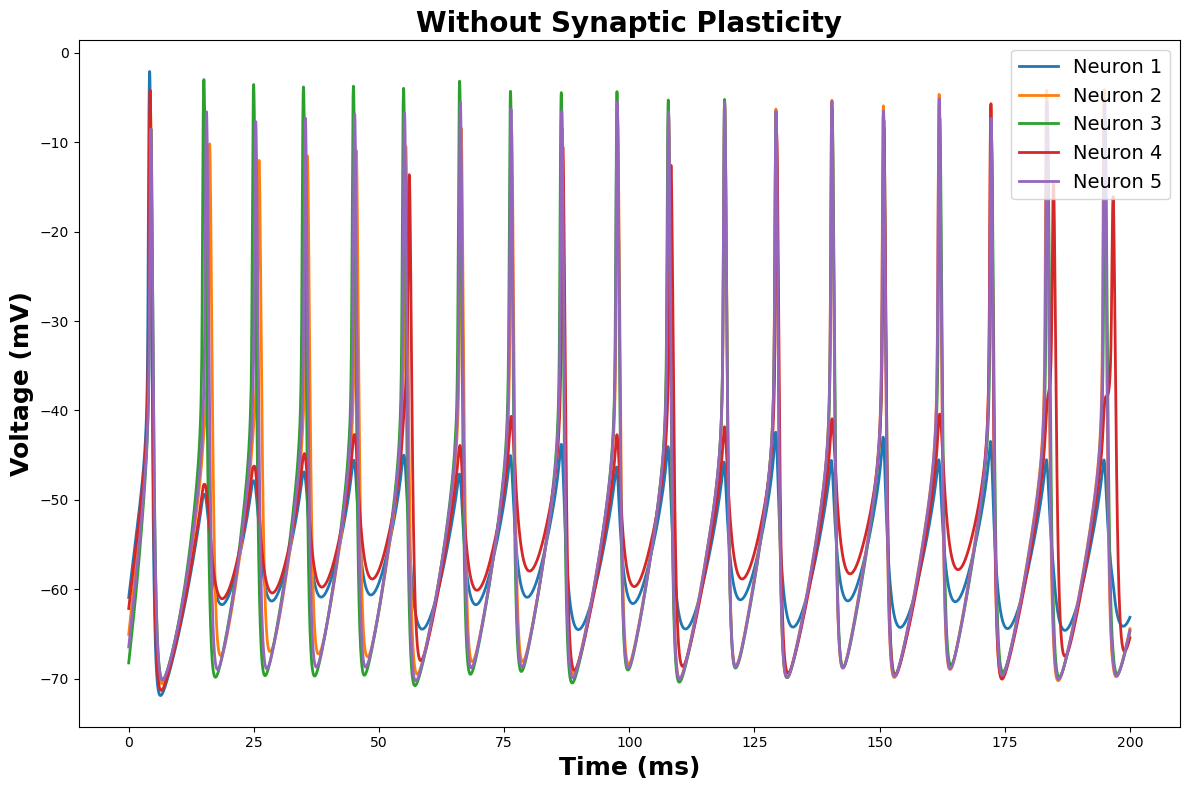

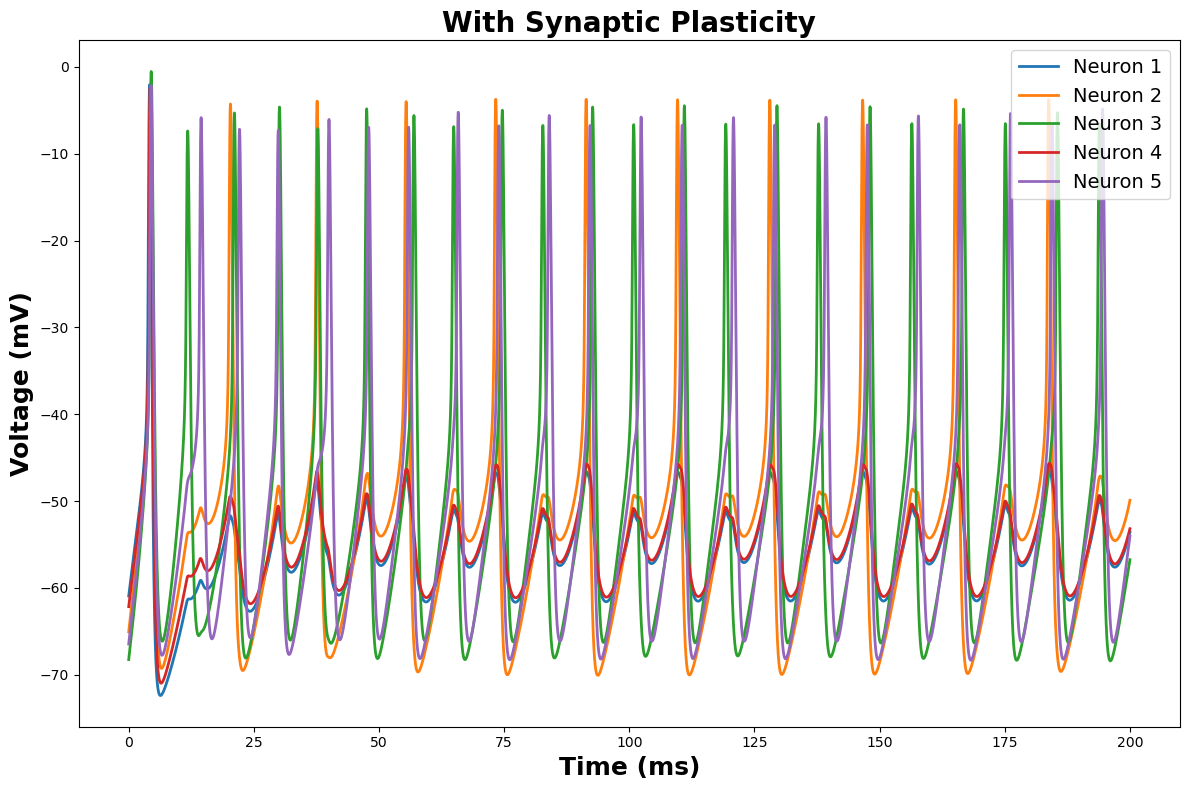

In [25]:
# Time
t_total = 200
dt = 0.001
t_eval = np.arange(0, t_total, dt)
Esyn = -80
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV, dh, dr, ds = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i], h[i]) + I_K(V[i], h[i]) + I_T(V[i], r[i])
        Isyn = sum(g_matrix[i, j] * s[j] * (V[i] - Esyn) for j in range(N) if j != i)
        dV[i] = -Iion + I_stim[i] - 1/(N-1) * Isyn
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])


V0 = np.random.uniform(-70, -60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0, h0, r0, s0])

g_static = np.full((N, N), 1)
np.fill_diagonal(g_static, 0)
sol_static = solve_ivp(full_model, [0, t_total], y0, t_eval=t_eval, args=(g_static,))

g_dynamic = np.random.uniform(0, 0.1, (N, N))
np.fill_diagonal(g_dynamic, 0)

Y_stdp = []
y = y0.copy()
last_spikes = np.full(N, -100.0)

for t_idx, t in enumerate(t_eval):
    dy = full_model(t, y, g_dynamic)
    y += dy * dt
    Y_stdp.append(y.copy())

    # Detect spike
    V = y[:N]
    for i in range(N):
        if V[i] > -30 and last_spikes[i] < t - 3:
            for j in range(N):
                if i != j:
                    delta_t = last_spikes[j] - t
                    g_dynamic[i, j] = stdp_update(g_dynamic[i, j], delta_t)
                    delta_t_rev = t - last_spikes[j]
                    g_dynamic[j, i] = stdp_update(g_dynamic[j, i], delta_t_rev)
            last_spikes[i] = t 

Y_stdp = np.array(Y_stdp).T


plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, sol_static.y[i, :], label=f'Neuron {i+1}', linewidth=2)
plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=18, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=18, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig('StaticInhibitory.png')
plt.show()

# Plot for STDP coupling with improved styling
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i, :], label=f'Neuron {i+1}', linewidth=2)
plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=18, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=18, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig('STDPInhibitory.png')
plt.show()



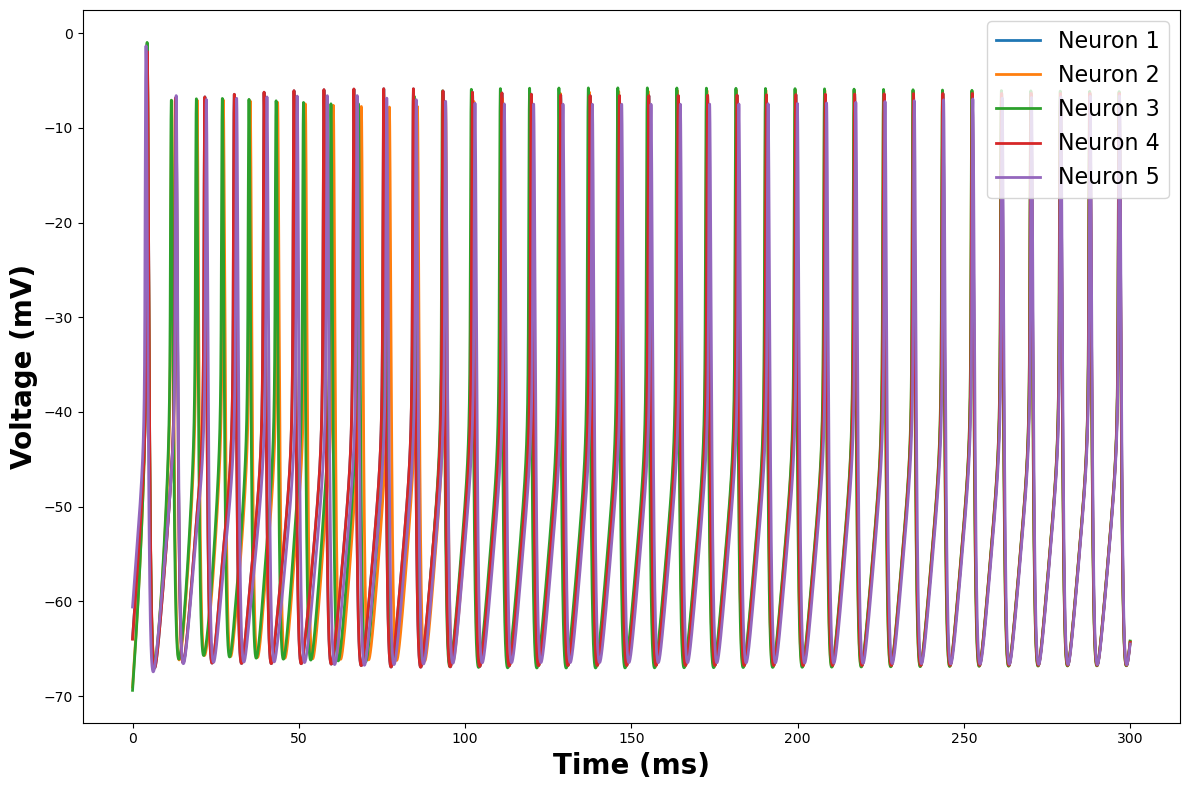

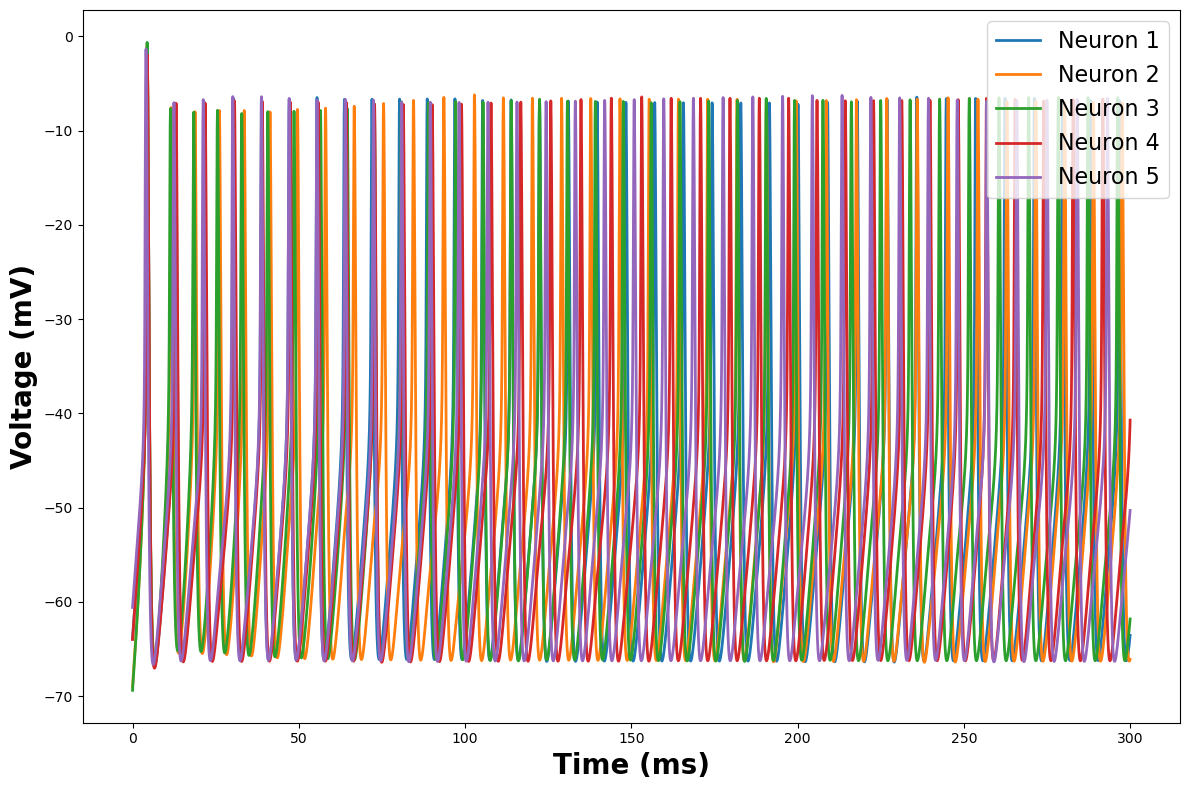

In [29]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------- Parameters ----------
N       = 5
C       = 1.0
Esyn    = -80.0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 300.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous
# ---------- Gating & synapse kinetics ----------
def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

# ---------- Full model RHS ----------
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

# ---------- Initial conditions ----------
V0 = np.random.uniform(-70,-60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

# ---------- 1) Static network (forward Euler for consistency) ----------
g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

# ---------- 2) Plastic network (forward Euler + correct STDP) ----------
g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

# ---------- Plotting ----------
plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('WithoutSTDPInhibitory')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('WithSTDPInhibitory')
plt.show()


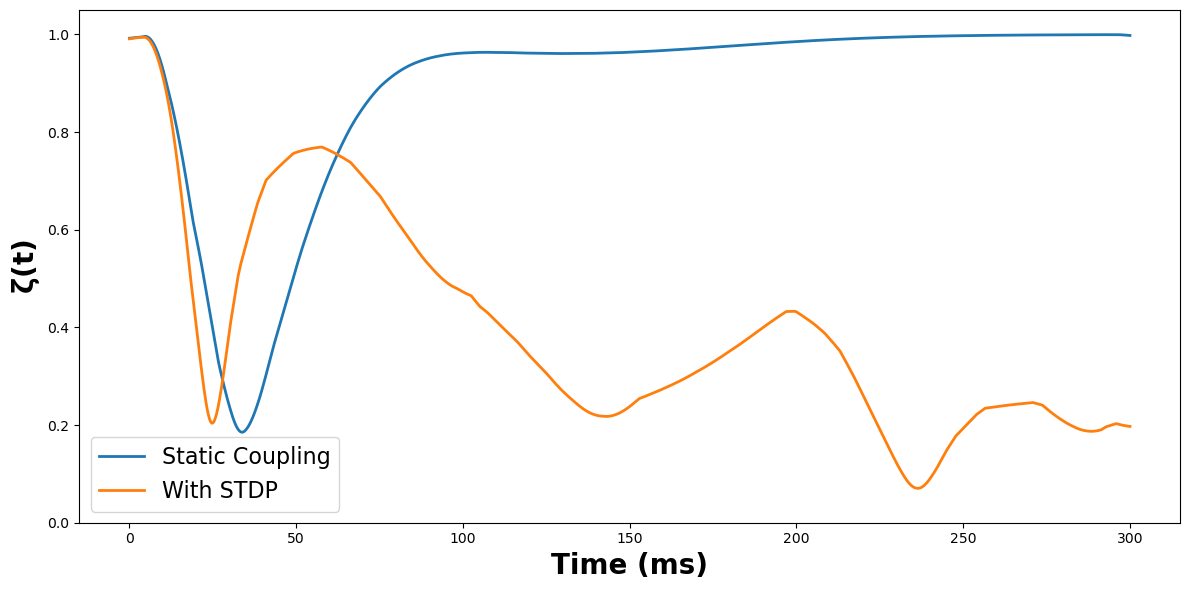

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    """
    V_traces: array (N, T) of voltages over time
    t_eval:    array (T,) of timepoints
    returns:   phases (N,T), R (T,)
    """
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoInhib.png')
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------- Parameters ----------
N       = 5
C       = 1.0
Esyn    = 0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 300.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous
# ---------- Gating & synapse kinetics ----------
def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

# ---------- Full model RHS ----------
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

# ---------- Initial conditions ----------
V0 = np.random.uniform(-75,-55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

# ---------- 1) Static network (forward Euler for consistency) ----------
g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

# ---------- 2) Plastic network (forward Euler + correct STDP) ----------
g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

# ---------- Plotting ----------
plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('WithoutSTDPExcitatory')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('WithSTDPExcitatory')
plt.show()


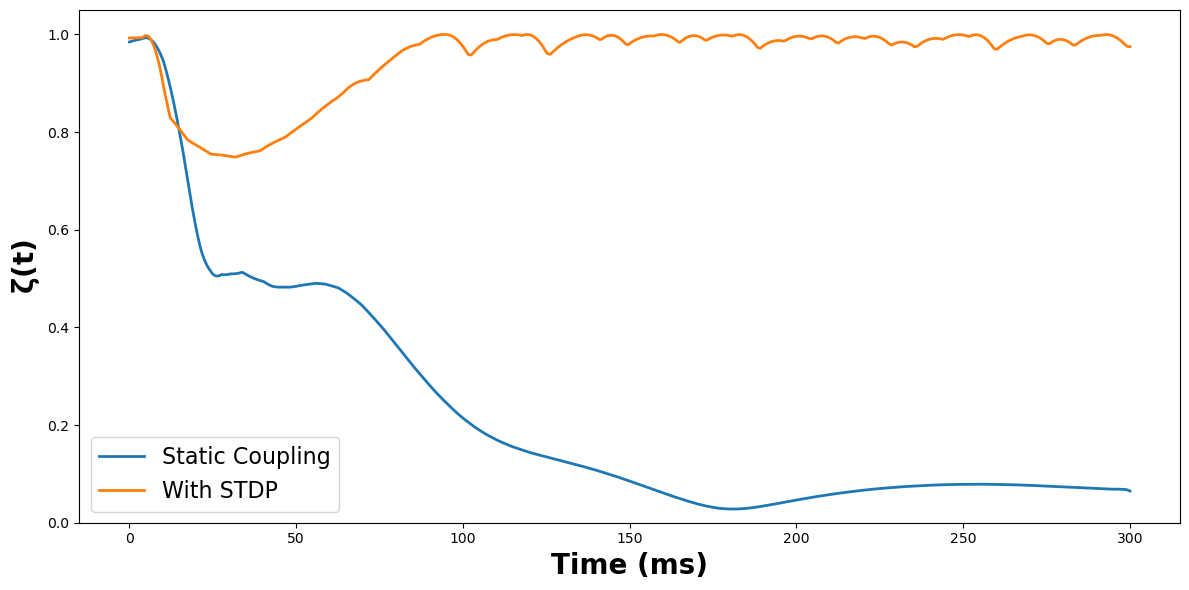

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    """
    V_traces: array (N, T) of voltages over time
    t_eval:    array (T,) of timepoints
    returns:   phases (N,T), R (T,)
    """
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoExcit.png')
plt.show()


C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp((V+41)/4))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp((V+84)/4))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-(V+37)/7))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:16: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-(V+60)/6.2))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:6: RuntimeWarning: overflow encountered in exp
  return 0.128*np.exp(-((V+46)/18))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\540308325.py:8: RuntimeWarning: overflow encountered in exp
  return 4/(1+np.exp(-(V+23)/5))
C:\Users\21310556\AppData\Local\Temp\ipykernel_13620\1314721621.py:13: RuntimeWarning: divide by zero encountered in sc

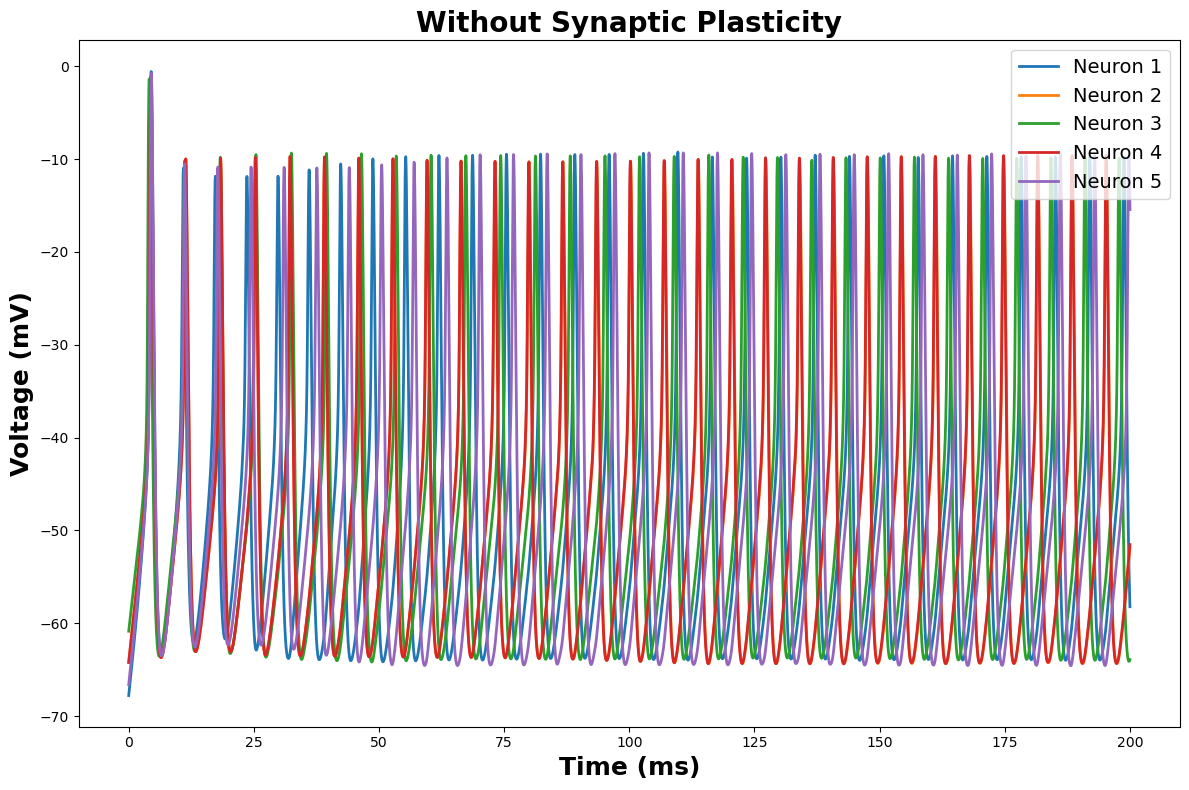

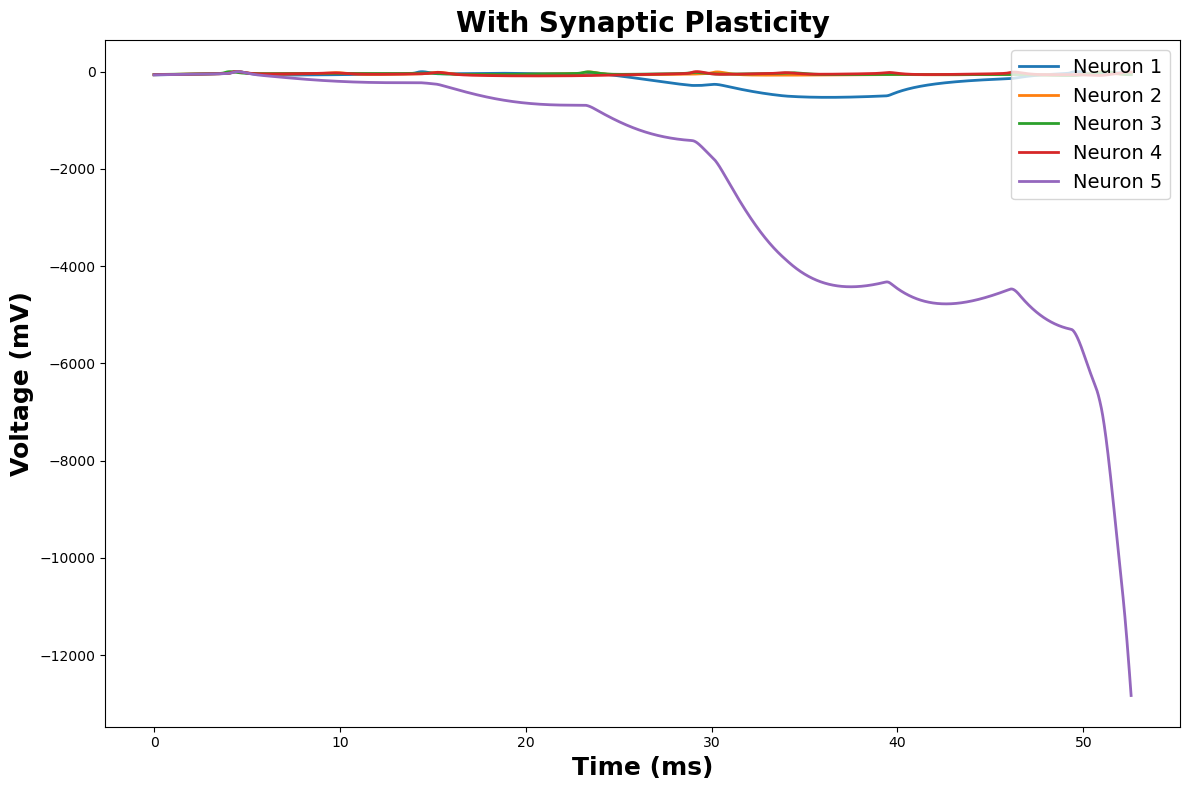

In [13]:
# Time
t_total = 200
dt = 0.001
t_eval = np.arange(0, t_total, dt)
Esyn = 0
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV, dh, dr, ds = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i], h[i]) + I_K(V[i], h[i]) + I_T(V[i], r[i])
        Isyn = sum(g_matrix[i, j] * s[j] * (V[i] - Esyn) for j in range(N) if j != i)
        dV[i] = -Iion + I_stim[i] - 1/(N-1) * Isyn
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])


V0 = np.random.uniform(-70, -60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0, h0, r0, s0])

g_static = np.full((N, N), 0.1)
np.fill_diagonal(g_static, 0)
sol_static = solve_ivp(full_model, [0, t_total], y0, t_eval=t_eval, args=(g_static,))

g_dynamic = np.random.uniform(0, 1, (N, N))
np.fill_diagonal(g_dynamic, 0)

Y_stdp = []
y = y0.copy()
last_spikes = np.full(N, -100.0)

for t_idx, t in enumerate(t_eval):
    dy = full_model(t, y, g_dynamic)
    y += dy * dt
    Y_stdp.append(y.copy())

    # Detect spike
    V = y[:N]
    for i in range(N):
        if V[i] > -30 and last_spikes[i] < t - 5:
            for j in range(N):
                if i != j:
                    delta_t = last_spikes[j] - t
                    g_dynamic[i, j] = stdp_update(g_dynamic[i, j], delta_t)
                    delta_t_rev = t - last_spikes[j]
                    g_dynamic[j, i] = stdp_update(g_dynamic[j, i], delta_t_rev)
            last_spikes[i] = t 

Y_stdp = np.array(Y_stdp).T


plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, sol_static.y[i, :], label=f'Neuron {i+1}', linewidth=2)
plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=18, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=18, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig('StaticExcitatory.png')
plt.show()

# Plot for STDP coupling with improved styling
plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i, :], label=f'Neuron {i+1}', linewidth=2)
plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=18, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=18, fontweight='bold')
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig('STDPExcitatory.png')
plt.show()




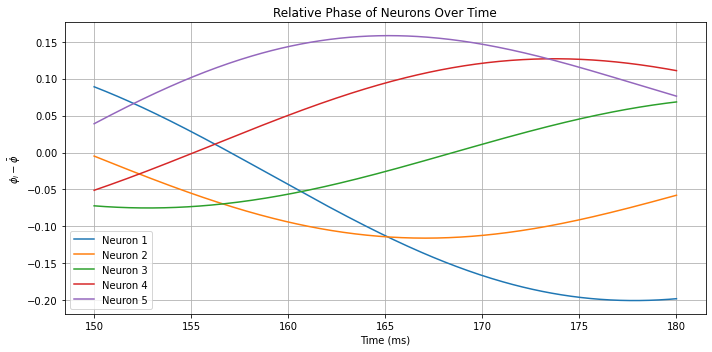

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up time
time = np.linspace(150, 180, 300)  # 300 points between 150 ms and 180 ms
n_neurons = 5

# Simulate some synthetic phase trajectories (centered around 0)
# This is just for illustration — real data would come from a model
np.random.seed(0)  # for reproducibility
phi = np.zeros((n_neurons, len(time)))
for i in range(n_neurons):
    phi[i] = 0.05 * (i - 2) * (time - 150) / 30 + 0.1 * np.sin(0.1 * time + i)

# Subtract the mean phase at each time step
phi_mean = np.mean(phi, axis=0)
phi_rel = phi - phi_mean

# Plot
plt.figure(figsize=(10, 5))
for i in range(n_neurons):
    plt.plot(time, phi_rel[i], label=f'Neuron {i+1}')

plt.xlabel('Time (ms)')
plt.ylabel(r'$\phi_i - \bar{\phi}$')
plt.title('Relative Phase of Neurons Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


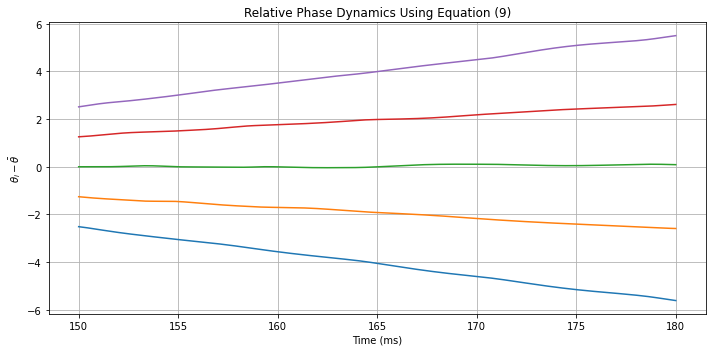

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Parameters ---
N = 5                       # Number of neurons
t_span = (0, 30)            # ms
t_eval = np.linspace(*t_span, 1000)
epsilon = 0.1
K_hat = 1.0                 # Using K_hat = K / (epsilon * C)
Esyn = -1.0                 # Synaptic reversal potential

# Heterogeneous natural frequencies
omega = np.linspace(0.9, 1.1, N)

# Dummy periodic functions for Z(θ), s(θ), V(θ)
def Z(theta): return np.sin(theta)
def s(theta): return np.exp(-((theta % (2*np.pi)) - np.pi)**2 / 0.5)
def V(theta): return np.cos(theta)

# Initial phases
theta0 = np.linspace(0, 2*np.pi, N, endpoint=False)

# Static synaptic weights g_{j→i}, excluding self-connections
g = np.ones((N, N)) - np.eye(N)

# --- ODE for dθ/dt as in Equation (9) ---
def dtheta_dt(t, theta):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction_sum = 0
        for j in range(N):
            if j != i:
                interaction = Z(theta[i]) * g[j, i] * s(theta[j]) * (V(theta[i]) - Esyn)
                interaction_sum += interaction
        dtheta[i] = omega[i] - epsilon * (K_hat / (N - 1)) * interaction_sum
    return dtheta

# Solve the ODE
sol = solve_ivp(dtheta_dt, t_span, theta0, t_eval=t_eval)

# --- Compute Relative Phase θi - mean(θ) ---
theta = sol.y
theta_mean = np.mean(theta, axis=0)
theta_rel = theta - theta_mean

# --- Plotting ---
plt.figure(figsize=(10, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(N):
    plt.plot(t_eval + 150, theta_rel[i], label=f'Neuron {i+1}', color=colors[i])
plt.xlabel("Time (ms)")
plt.ylabel(r"$\theta_i - \bar{\theta}$")
plt.title("Relative Phase Dynamics Using Equation (9)")
plt.grid(True)
plt.tight_layout()
plt.show()
